In [1]:
from fastai2.vision.all import *
from fastai2.vision.gan import *

In [2]:
from PIL import ImageDraw, ImageFont
class Crappifier():
    "Quickly draw tesxt and numbers on an image"
    def __init__(self, path_lr, path_hr):
        self.path_lr = path_lr
        self.path_hr = path_hr              

    def __call__(self, fn):       
        dest = self.path_lr/fn.relative_to(self.path_hr)    
        dest.parent.mkdir(parents=True, exist_ok=True)
        img = Image.open(fn)
        targ_sz = resize_to(img, 40,use_min=True)
        img = img.resize(targ_sz, resample=Image.BILINEAR).convert('RGB')
        w,h = img.size
        q = random.randint(10,70)
        ImageDraw.Draw(img).text((random.randint(0,w//2),random.randint(0,h//2)), str(q), fill=(255,255,255))
        img.save(dest, quality=q)

In [3]:
path_hr = 'Train Images'
path_lr = 'crappy'

In [4]:
items = get_image_files(path_hr)


In [5]:
c=Crappifier(path_lr, path_hr)
for item in items:
    c(item)

In [6]:
bad_im = get_image_files(path_lr)


In [7]:
im1 = PILImage.create(items[0])
im2 = PILImage.create(bad_im[0])

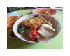

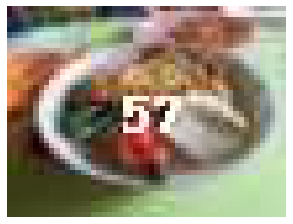

In [8]:
im1.show(); im2.show(figsize=(5,5))


In [9]:
dblock = DataBlock(blocks=(ImageBlock, ImageBlock),
                   get_items=get_image_files,
                   get_y = lambda x: path_hr/x.name,
                   splitter=RandomSplitter(),
                   item_tfms=Resize(224),
                   batch_tfms=[*aug_transforms(max_zoom=2.),
                               Normalize.from_stats(*imagenet_stats)])

In [10]:
bad_im

(#5983) [Path('crappy/image10.jpg'),Path('crappy/image10000.jpg'),Path('crappy/image10002.jpg'),Path('crappy/image10003.jpg'),Path('crappy/image10004.jpg'),Path('crappy/image10006.jpg'),Path('crappy/image10007.jpg'),Path('crappy/image1001.jpg'),Path('crappy/image10011.jpg'),Path('crappy/image10013.jpg')...]

In [11]:
items

(#5983) [Path('Train Images/image10.jpg'),Path('Train Images/image10000.jpg'),Path('Train Images/image10002.jpg'),Path('Train Images/image10003.jpg'),Path('Train Images/image10004.jpg'),Path('Train Images/image10006.jpg'),Path('Train Images/image10007.jpg'),Path('Train Images/image1001.jpg'),Path('Train Images/image10011.jpg'),Path('Train Images/image10013.jpg')...]

In [12]:
path='Train Images'
def get_dls(bs:int, size:int):
    "Generates two `GAN` DataLoaders"
    dblock = DataBlock(blocks=(ImageBlock, ImageBlock),
               get_items=get_image_files,
               get_y = lambda x: Path(path_hr)/x.name,
               splitter=RandomSplitter(),
               item_tfms=Resize(size),
               batch_tfms=[*aug_transforms(max_zoom=2.),
                           Normalize.from_stats(*imagenet_stats)])
    dls = dblock.dataloaders(path_lr, bs=bs, path=path,num_workers=0)
    dls.c = 3 # For 3 channel image
    return dls

In [13]:
dls_gen = get_dls(16,128)

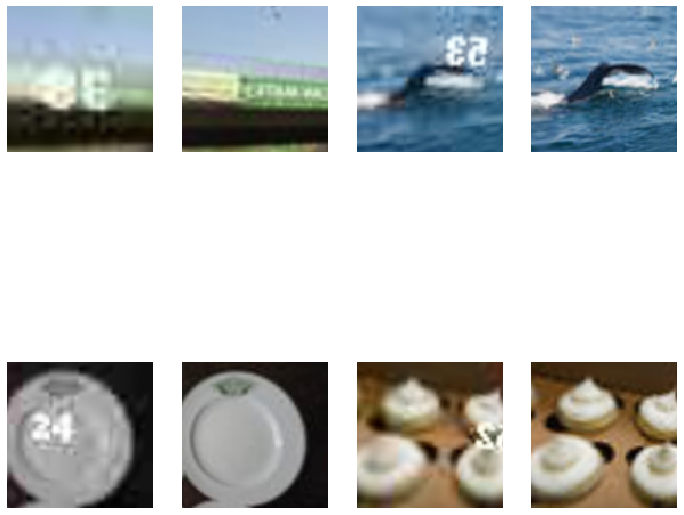

In [14]:
dls_gen.show_batch(max_n=4, figsize=(12,12))



In [15]:
wd, y_range, loss_gen = 1e-3, (-3., 3.), MSELossFlat()


In [16]:
bbone = resnet34
cfg = unet_config(blur=True, norm_type=NormType.Weight, self_attention=True,
                  y_range=y_range)

In [17]:
def create_gen_learner():
    return unet_learner(dls_gen, bbone, loss_func=loss_gen,
                      config=cfg)

In [18]:
learn_gen = create_gen_learner()


In [19]:
learn_gen.fit_one_cycle(2, pct_start=0.8, wd=wd)


epoch,train_loss,valid_loss,time
0,0.134719,0.114391,03:06
1,0.110357,0.101418,02:58


In [20]:
learn_gen.unfreeze()


In [21]:
learn_gen.fit_one_cycle(3, slice(1e-6,1e-3), wd=wd)


epoch,train_loss,valid_loss,time
0,0.111215,0.101616,03:16
1,0.103534,0.095250,03:14
2,0.100391,0.094274,03:14


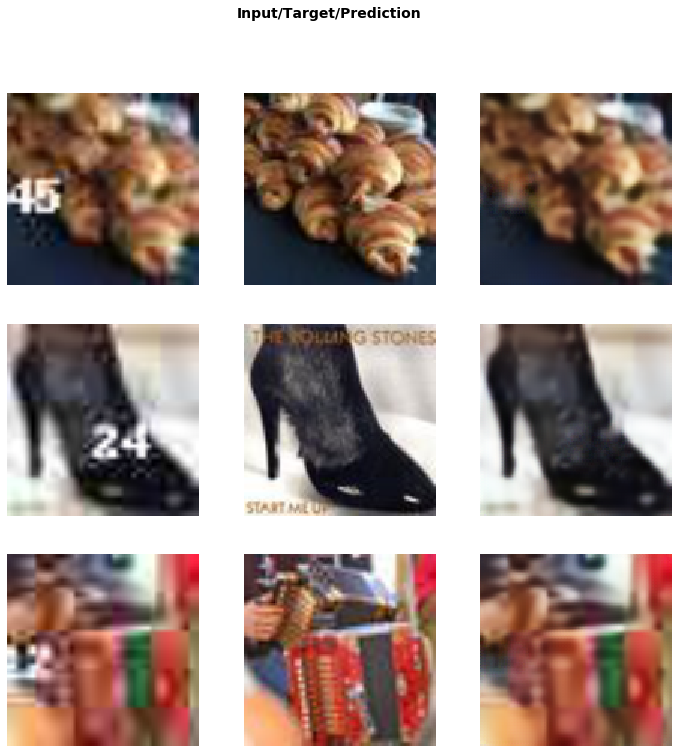

In [22]:
learn_gen.show_results(max_n=4, figsize=(12,12))


In [24]:
learn_gen.save('gen-pre2')


In [25]:
name_gen = 'image_gen'
path_gen = Path(name_gen)

In [26]:
path_gen.mkdir(exist_ok=True)


In [27]:
def save_preds(dl, learn):
    "Save away predictions"
    names = dl.dataset.items

    preds,_ = learn.get_preds(dl=dl)
    for i,pred in enumerate(preds):
        dec = dl.after_batch.decode((TensorImage(pred[None]),))[0][0]
        arr = dec.numpy().transpose(1,2,0).astype(np.uint8)
        Image.fromarray(arr).save(path_gen/names[i].name)

In [28]:
dl = dls_gen.train.new(shuffle=False, drop_last=False, 
                       after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])

In [29]:
preds, _ = learn_gen.get_preds(dl=dl)
